# **Classification des lésions cutanées par convolution de réseaux de neurones:**

### 1. téléchargement de données
Vous devez d'abord télécharger le fichier kaggle qui contient KAGGLE TOKEN) 

Il est necessaire pour télécharger la base de données

**Recommendation : Exécution sous Google COLAB**


In [ ]:
from google.colab import files
print("fichier Kaggle (token) : ")
uploaded = files.upload()

fichier Kaggle (token) : 


Saving kaggle.json to kaggle.json


Téléchargement des donneés

In [ ]:
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/ # faut addapter le path de fichier kaggle.json si different
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d kmader/skin-cancer-mnist-ham10000
!unzip /content/skin-cancer-mnist-ham10000.zip

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
  inflating: ham10000_images_part_2/ISIC_0029325.jpg  
  inflating: ham10000_images_part_2/ISIC_0029326.jpg  
  inflating: ham10000_images_part_2/ISIC_0029327.jpg  
  inflating: ham10000_images_part_2/ISIC_0029328.jpg  
  inflating: ham10000_images_part_2/ISIC_0029329.jpg  
  inflating: ham10000_images_part_2/ISIC_0029330.jpg  
  inflating: ham10000_images_part_2/ISIC_0029331.jpg  
  inflating: ham10000_images_part_2/ISIC_0029332.jpg  
  inflating: ham10000_images_part_2/ISIC_0029333.jpg  
  inflating: ham10000_images_part_2/ISIC_0029334.jpg  
  inflating: ham10000_images_part_2/ISIC_0029335.jpg  
  inflating: ham10000_images_part_2/ISIC_0029336.jpg  
  inflating: ham10000_images_part_2/ISIC_0029337.jpg  
  inflating: ham10000_images_part_2/ISIC_0029338.jpg  
  inflating: ham10000_images_part_2/ISIC_0029339.jpg  
  inflating: ham10000_images_part_2/ISIC_0029340.jpg  
  inflating: ham10000_images_part_2/ISIC_0

### 2. Librairies
on utilise les librairies keras de Tensorflow

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import math
import pandas as pd
import seaborn as sns
import os
import itertools
from glob import glob
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import keras
from tensorflow.keras import backend
from keras.utils.np_utils import to_categorical
from tensorflow.keras.models import Sequential, model_from_json, Model, load_model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, Callback, CSVLogger
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3, ResNet152V2, VGG16

#To see the value of multiple statements at once.
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [ ]:
import tensorflow as tf
tf.keras.backend.clear_session()

### 3. Créer des classes et définir des fonctions

##### Classe permettant de conserver l'historique du modèle pendant l'apprentissage.

In [ ]:
import time
class TimeHistory(Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, epoch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, epoch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)

Root Mean Squared Error (RMSE)

In [ ]:
def rmse(y_true, y_pred):
    return backend.sqrt(backend.mean(backend.square(y_pred - y_true), axis=-1))

##### Fonction pour ajouter des couches supplémentaires après le CNN de base pré-entraîné pour aligner les nombres de paramètres et les sorties.

In [ ]:
def add_cnn_layers(base_model, model):
    model.add(base_model)
    model.add(Conv2D(64, (3, 3), activation = 'relu', padding='same'))
    model.add(MaxPool2D(pool_size = (2, 2)))
    model.add(Dropout(0.40))
    model.add(Flatten())
    model.add(Dense(128,activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(7, activation='softmax'))
    model.summary()
    return model

##### Fonction permettant de calculer apprentissage + précision d'ensemple de validation + loss + l'erreur


In [ ]:
def train_val_accuracy(model, x_train_normalized, x_val_normalized, y_train, y_val):
    train_loss, train_accuracy, train_mse, train_mape, train_rmse = model.evaluate(x_train_normalized, y_train, verbose=1)
    val_loss, val_accuracy, val_mse, val_mape, val_rmse = model.evaluate(x_val_normalized, y_val, verbose=1)
    
    #Accuracy
    print("Training Accuracy:",train_accuracy*100,"%","")
    print("Validation Accuracy:",val_accuracy*100,"%","")

    #Loss
    print("\nTraining Loss:",train_loss)
    print("Validation Loss:",val_loss)

    #RMSE
    print("\nTraining RMSE:",train_rmse)
    print("Validation RMSE:",val_rmse)

    #MSE
    print("\nTraining MSE:",train_mse)
    print("Validation MSE:",val_mse)

    #MAPE
    print("\nTraining MAPE:",train_mape)
    print("Validation MAPE:",val_mape)

##### Function pour calculer   précision + loss + erreurs sur l'ensemle de test




In [ ]:
def test_accuracy(model, x_test_normalized, y_test):
    test_loss, test_accuracy, test_mse, test_mape, test_rmse = model.evaluate(x_test_normalized, y_test, verbose=1)

    print("\nTest Set Accuracy: ", test_accuracy*100,"%", 
          "\nTest Set Loss:", test_loss,
          "\nTest Set RMSE:", test_rmse,
          "\nTest Set MSE:", test_mse,
          "\nTest Set MAPE:", test_mape)

##### Function pour tracer  précision + loss + erreur par  Epoch

> Indented block



In [ ]:
def plot_model_history(model_history, name):
    fig, axs = plt.subplots(2, 2, figsize=(15,15))
    
    #précision
    axs[0,0].plot(range(1,len(model_history.history['accuracy'])+1),model_history.history['accuracy'])
    axs[0,0].plot(range(1,len(model_history.history['val_accuracy'])+1),model_history.history['val_accuracy'])
    axs[0,0].set_title('Model Accuracy')
    axs[0,0].set_ylabel('Accuracy')
    axs[0,0].set_xlabel('Epoch')
    axs[0,0].set_xticks(np.arange(1,len(model_history.history['accuracy'])+1),len(model_history.history['accuracy'])/10)
    axs[0,0].legend(['train', 'validation'], loc='best')
    
    #loss
    axs[0,1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[0,1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[0,1].set_title('Model Loss')
    axs[0,1].set_ylabel('Loss')
    axs[0,1].set_xlabel('Epoch')
    axs[0,1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[0,1].legend(['train', 'validation'], loc='best')
    
    #RMSE
    axs[1,0].plot(range(1,len(model_history.history['rmse'])+1),model_history.history['rmse'])
    axs[1,0].plot(range(1,len(model_history.history['val_rmse'])+1),model_history.history['val_rmse'])
    axs[1,0].set_title('Model RMSE')
    axs[1,0].set_ylabel('RMSE')
    axs[1,0].set_xlabel('Epoch')
    axs[1,0].set_xticks(np.arange(1,len(model_history.history['rmse'])+1),len(model_history.history['rmse'])/10)
    axs[1,0].legend(['train', 'validation'], loc='best')
    
    #MSE
    axs[1,1].plot(range(1,len(model_history.history['mse'])+1),model_history.history['mse'])
    axs[1,1].plot(range(1,len(model_history.history['val_mse'])+1),model_history.history['val_mse'])
    axs[1,1].set_title('Model MSE')
    axs[1,1].set_ylabel('MSE')
    axs[1,1].set_xlabel('Epoch')
    axs[1,1].set_xticks(np.arange(1,len(model_history.history['mse'])+1),len(model_history.history['mse'])/10)
    axs[1,1].legend(['train', 'validation'], loc='best')
    
    #Plot and save figures
    plt.show()
    fig.savefig('/content/drive/MyDrive/souad Models/' + name + '_model_history.png', dpi=300)

##### Function pour calculer les classes prédit par le model et renvoyer la classe réel (supervisé)

In [ ]:
def cal_true_pred_classes(model, x_test_normalized, y_test):
    #Predire the la classe (neurone active)
    y_predict = model.predict(x_test_normalized)
    y_predict_classes = np.argmax(y_predict, axis = 1) 
    y_true_classes = np.argmax(y_test, axis = 1) 
    return y_predict_classes, y_true_classes

#### Function pour tracer la matrice de confusion

---

labels

In [ ]:
def create_confusion_matrix(model, x_test_normalized, y_test, cm_plot_labels, name):
    #Get the true and predicted labels
    y_predict_classes, y_true_classes = cal_true_pred_classes(model, x_test_normalized, y_test)

    #Compute the confusion matrix
    confusion_matrix_computed = confusion_matrix(y_true_classes, y_predict_classes)

    #Plot the confusion matrix
    plot_confusion_matrix(confusion_matrix_computed, cm_plot_labels, name) 

##### confusion

In [ ]:
def plot_confusion_matrix(cm, classes,
                          name,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    plt.figure(figsize=(8,6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(name)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    
#     b, t = plt.ylim()
#     b += 0.5
#     t -= 0.5
#     plt.ylim(b, t)
    
    plt.tight_layout()
    plt.ylabel('True Labels')
    plt.xlabel('Predicted Labels')
    fig = plt
    fig.savefig('/content/drive/MyDrive/souad Models/' + name + '_confusion_matrix.png', dpi=300)

##### Function pour  generer le rapport de classification

In [ ]:
def gen_classification_report(model, x_test_normalized, y_test, cm_plot_labels):
    y_predict_classes, y_true_classes = cal_true_pred_classes(model, x_test_normalized, y_test)
    report = classification_report(y_true_classes, y_predict_classes, target_names = cm_plot_labels)
    print(report)

##### Function pour trouver la classe la plus précise %

In [ ]:
def plot_label_classification_acc(model, x_test_normalized, y_test, cm_plot_labels, name):

    #Get the true and predicted labels
    y_predict_classes, y_true_classes = cal_true_pred_classes(model, x_test_normalized, y_test)
        
    #Compute the confusion matrix
    confusion_matrix_computed = confusion_matrix(y_true_classes, y_predict_classes)

    #Calculation confusion matrix prediction error
    cm_prediction_error = (np.diag(confusion_matrix_computed) / np.sum(confusion_matrix_computed, axis=1))* 100

    #Bar plot
    plt.bar(np.arange(7), cm_prediction_error)

    #Plot title and labels
    plt.title(name)
    plt.xlabel('True Labels')
    plt.ylabel('Classified Labels %')
    
    #Save figure
    fig = plt
    fig.savefig('/content/drive/MyDrive/souad Models/' + name + '_label_classification_accuracy.png', dpi=300)

### 4. Creation de dossier pour les images et les labels

In [ ]:
base_skin_dir = os.path.join('..', '/content/')# '/content/' si vous etes dans google colab, si non, à adapter


##### extraire les noms des images

In [ ]:
imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(base_skin_dir, '*', '*.jpg'))}

##### Dictionnaire pour hasher les classes

In [ ]:
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

### 5. lire les données

##### information de la base donneés (metadata)

In [ ]:
skin_df = pd.read_csv(os.path.join(base_skin_dir, 'HAM10000_metadata.csv'))

##### ajoutter de nouvelles colonnes pour une meilleure anaylse

In [ ]:
skin_df['path'] = skin_df['image_id'].map(imageid_path_dict.get) #path locale des images
skin_df['cell_type'] = skin_df['dx'].map(lesion_type_dict.get) #Full 'dx' name
skin_df['cell_type_idx'] = pd.Categorical(skin_df['cell_type']).codes #Unique code for each 'dx'

##### 5 premieres ligne de la metadata

In [ ]:
skin_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,/content/ham10000_images_part_1/ISIC_0027419.jpg,Benign keratosis-like lesions,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,/content/ham10000_images_part_1/ISIC_0025030.jpg,Benign keratosis-like lesions,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,/content/ham10000_images_part_1/ISIC_0026769.jpg,Benign keratosis-like lesions,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,/content/ham10000_images_part_1/ISIC_0025661.jpg,Benign keratosis-like lesions,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,/content/HAM10000_images_part_2/ISIC_0031633.jpg,Benign keratosis-like lesions,2


##### Produire des statistiques descriptives sur l'ensemble de données (à l'exception des types numériques : age et cell_type_idx)




In [ ]:
skin_df.describe(exclude=[np.number])

,lesion_id,image_id,dx,dx_type,sex,localization,path,cell_type
count,10015,10015,10015,10015,10015,10015,10015,10015
unique,7470,10015,7,4,3,15,10015,7
top,HAM_0003789,ISIC_0025752,nv,histo,male,back,/content/HAM10000_images_part_2/ISIC_0030804.jpg,Melanocytic nevi
freq,6,1,6705,5340,5406,2192,1,6705


##### Produire des statistiques descriptives sur les types numériques de l'ensemble de données : age et cell_type_idx.

In [ ]:
skin_df.describe()

,age,cell_type_idx
count,9958.000000,10015.000000
mean,51.863828,3.623964
std,16.968614,1.208859
min,0.000000,0.000000
25%,40.000000,4.000000
50%,50.000000,4.000000
75%,65.000000,4.000000
max,85.000000,6.000000


##### dataypes

In [ ]:
print(skin_df.dtypes)


lesion_id         object
image_id          object
dx                object
dx_type           object
age              float64
sex               object
localization      object
path              object
cell_type         object
cell_type_idx       int8
dtype: object


D'après les statistiques affichées dans la dernière section, nous pouvons voir qu'il n'y a que 7470 identifiants de lésions uniques. Nous allons les filtrer.

##### Supprimez les numéros de lésions avec des images en double, en n'en gardant qu'une seule pour chaque numéro de lésion. Ces images sont de la même lésion exacte, mais avec un angle différent, un zoom différent, etc.

In [ ]:
skin_df = skin_df.drop_duplicates(subset='lesion_id')
skin_df

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,/content/HAM10000_images_part_1/ISIC_0027419.jpg,Benign keratosis-like lesions,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,/content/HAM10000_images_part_1/ISIC_0026769.jpg,Benign keratosis-like lesions,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,/content/ham10000_images_part_2/ISIC_0031633.jpg,Benign keratosis-like lesions,2
6,HAM_0002761,ISIC_0029176,bkl,histo,60.0,male,face,/content/HAM10000_images_part_1/ISIC_0029176.jpg,Benign keratosis-like lesions,2
8,HAM_0005132,ISIC_0025837,bkl,histo,70.0,female,back,/content/HAM10000_images_part_1/ISIC_0025837.jpg,Benign keratosis-like lesions,2
...,...,...,...,...,...,...,...,...,...,...
9994,HAM_0000193,ISIC_0030877,akiec,histo,60.0,female,face,/content/ham10000_images_part_2/ISIC_0030877.jpg,Actinic keratoses,0
10001,HAM_0000020,ISIC_0031922,akiec,histo,60.0,female,face,/content/ham10000_images_part_2/ISIC_0031922.jpg,Actinic keratoses,0
10004,HAM_0005579,ISIC_0029309,akiec,histo,80.0,male,face,/content/ham10000_images_part_2/ISIC_0029309.jpg,Actinic keratoses,0
10008,HAM_0001576,ISIC_0033705,akiec,histo,60.0,male,face,/content/ham10000_images_part_2/ISIC_0033705.jpg,Actinic keratoses,0


In [ ]:
skin_df.isnull().sum()

lesion_id         0
image_id          0
dx                0
dx_type           0
age              52
sex               0
localization      0
path              0
cell_type         0
cell_type_idx     0
dtype: int64

##### Remplacement des valeurs NA dans l'âge par la moyenne de l'âge dans l'ensemble de données

In [ ]:
skin_df['age'].fillna((skin_df['age'].mean()), inplace=True)

### 6. Traitement de données

##### Visualiser les distributions des 7 différentes catégories de lésions cutanées

<Figure size 864x288 with 0 Axes>

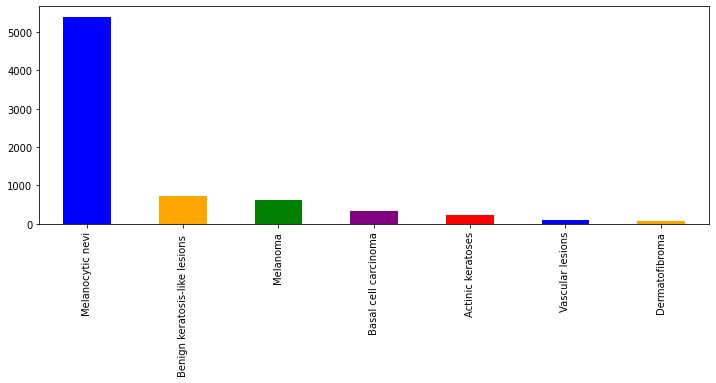

In [ ]:
plt.figure(figsize=(12, 4))
skin_df['cell_type'].value_counts().plot(kind='bar', color=["blue", "orange", "green", "purple", "red"])

In [ ]:
skin_df['cell_type'].value_counts()
skin_df['dx'].value_counts()

Melanocytic nevi                  5403
Benign keratosis-like lesions      727
Melanoma                           614
Basal cell carcinoma               327
Actinic keratoses                  228
Vascular lesions                    98
Dermatofibroma                      73
Name: cell_type, dtype: int64

nv       5403
bkl       727
mel       614
bcc       327
akiec     228
vasc       98
df         73
Name: dx, dtype: int64

On peut voir qu'il y a un énorme déséquilibre entre les classes, la majorité des images du jeu de données étant diagnostiquées dans la catégorie des naevus mélanocytaires [nv].

##### Visualize the distributions of the 4 different technical validation types

<Figure size 864x288 with 0 Axes>

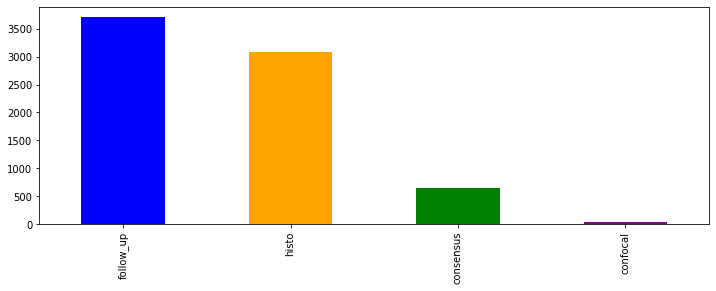

In [ ]:
plt.figure(figsize=(12, 4))
skin_df['dx_type'].value_counts().plot(kind='bar', color=["blue", "orange", "green", "purple"])

##### Visualiser les distributions des différentes localisations

<Figure size 864x288 with 0 Axes>

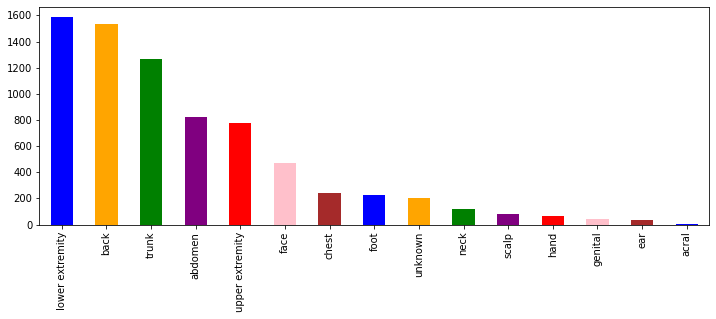

In [ ]:
plt.figure(figsize=(12, 4))
skin_df['localization'].value_counts().plot(kind='bar', color=["blue", "orange", "green", "purple", "red", "pink", "brown"])

On constate que le dos, les membres inférieurs et le tronc sont des régions fortement touchées par le cancer de la peau.

##### distrubution d'ages

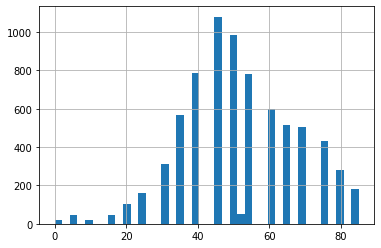

In [ ]:
skin_df['age'].hist(bins=40)

la majorité des patients sont entre of 35 ans and 70 ans.

### 7. Traitement et redimensionnement des images

In [ ]:
#la taille des images
im = Image.open(skin_df["path"][0])
width, height = im.size
print("Width: ", width)
print("Height:", height)

Width:  600
Height: 450


In [ ]:
# la réduction de la taille des images pour un apprentissage plus rapide 
width/= 4
height/= 4
print("Width: ", width)
print("Height:", height)

Width:  150.0
Height: 112.5


In [ ]:
#Redimensionnez les images et ajoutez les valeurs des pixels de l'image dans une nouvelle colonne du cadre de données de la peau :
skin_df['image'] = skin_df['path'].map(lambda x: np.asarray(Image.open(x).resize((int(width), int(height)))))

##### quelques exemples sur la base des donneés avec les classes

In [ ]:
skin_df['image'].map(lambda x: x.shape).value_counts()

(112, 150, 3)    7470
Name: image, dtype: int64

Text(0.5, 1.0, 'Actinic keratoses')

(-0.5, 149.5, 111.5, -0.5)

(-0.5, 149.5, 111.5, -0.5)

(-0.5, 149.5, 111.5, -0.5)

(-0.5, 149.5, 111.5, -0.5)

(-0.5, 149.5, 111.5, -0.5)

Text(0.5, 1.0, 'Basal cell carcinoma')

(-0.5, 149.5, 111.5, -0.5)

(-0.5, 149.5, 111.5, -0.5)

(-0.5, 149.5, 111.5, -0.5)

(-0.5, 149.5, 111.5, -0.5)

(-0.5, 149.5, 111.5, -0.5)

Text(0.5, 1.0, 'Benign keratosis-like lesions ')

(-0.5, 149.5, 111.5, -0.5)

(-0.5, 149.5, 111.5, -0.5)

(-0.5, 149.5, 111.5, -0.5)

(-0.5, 149.5, 111.5, -0.5)

(-0.5, 149.5, 111.5, -0.5)

Text(0.5, 1.0, 'Dermatofibroma')

(-0.5, 149.5, 111.5, -0.5)

(-0.5, 149.5, 111.5, -0.5)

(-0.5, 149.5, 111.5, -0.5)

(-0.5, 149.5, 111.5, -0.5)

(-0.5, 149.5, 111.5, -0.5)

Text(0.5, 1.0, 'Melanocytic nevi')

(-0.5, 149.5, 111.5, -0.5)

(-0.5, 149.5, 111.5, -0.5)

(-0.5, 149.5, 111.5, -0.5)

(-0.5, 149.5, 111.5, -0.5)

(-0.5, 149.5, 111.5, -0.5)

Text(0.5, 1.0, 'Melanoma')

(-0.5, 149.5, 111.5, -0.5)

(-0.5, 149.5, 111.5, -0.5)

(-0.5, 149.5, 111.5, -0.5)

(-0.5, 149.5, 111.5, -0.5)

(-0.5, 149.5, 111.5, -0.5)

Text(0.5, 1.0, 'Vascular lesions')

(-0.5, 149.5, 111.5, -0.5)

(-0.5, 149.5, 111.5, -0.5)

(-0.5, 149.5, 111.5, -0.5)

(-0.5, 149.5, 111.5, -0.5)

(-0.5, 149.5, 111.5, -0.5)

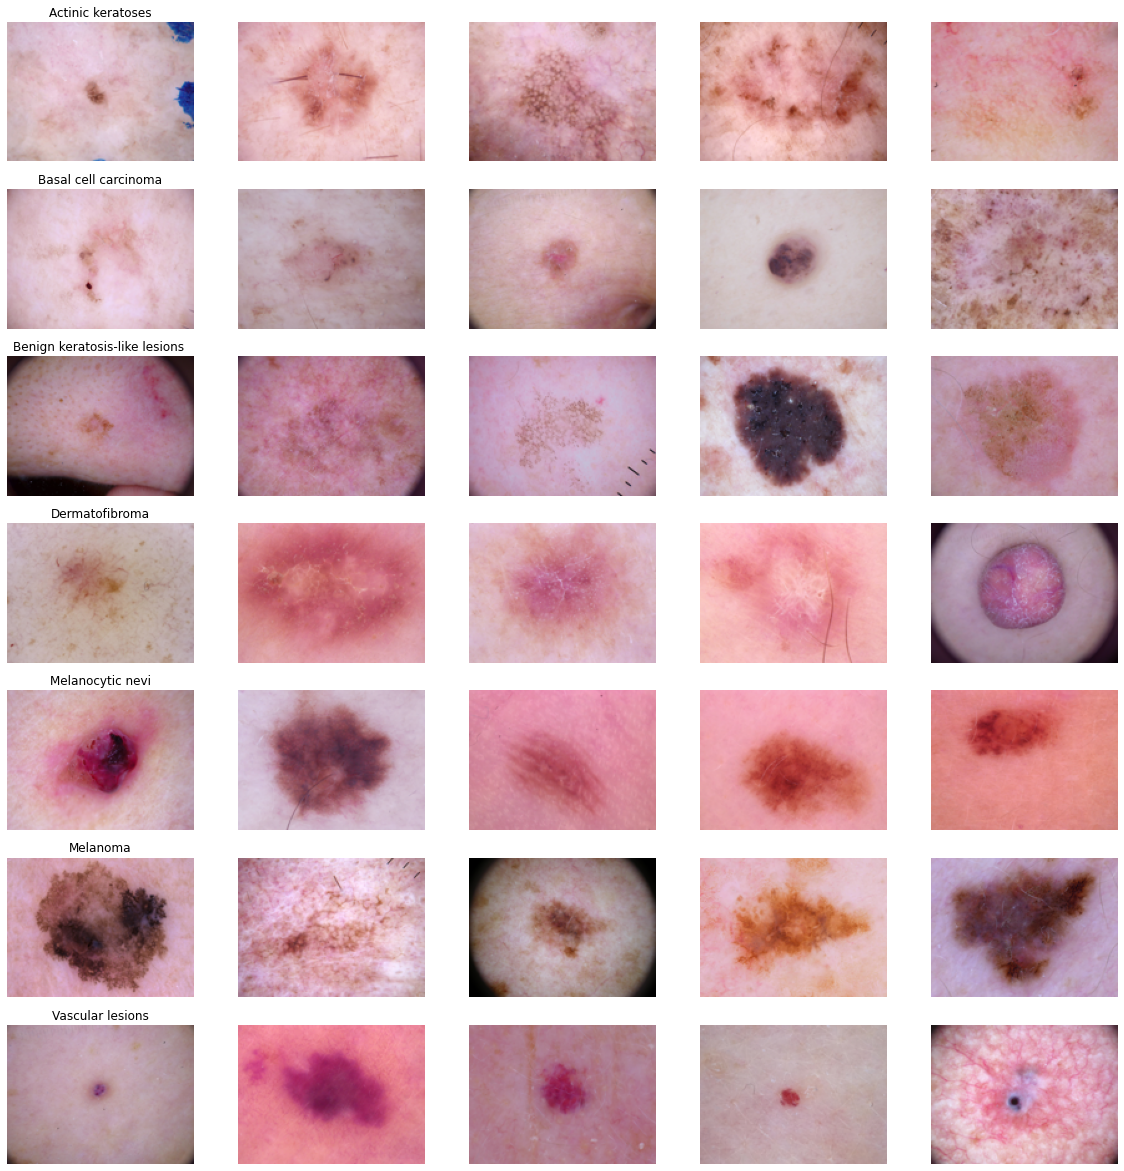

In [ ]:
n_samples = 5
fig, m_axs = plt.subplots(7, n_samples, figsize = (4*n_samples, 3*7))
for n_axs, (type_name, type_rows) in zip(m_axs, 
                                         skin_df.sort_values(['cell_type']).groupby('cell_type')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=2018).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')
fig.savefig('category_samples.png', dpi=300)

CHaque image a un index de type, "target"

In [ ]:
features=skin_df.drop(columns=['cell_type_idx'],axis=1)
target=skin_df['cell_type_idx']

In [ ]:
# Convertir les étiquettes numériques en une matrice binaire (one hot matrix)
num_classes = 7
target_encoded = to_categorical(target, num_classes = num_classes)
print(target_encoded)

[[0. 0. 1. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]]


### 8. chiox d'ensemble d'apprentissage, de validation et de test  

Nous divisons d'abord l'ensemble de données en 80 % de données de formation et 20 % de données de test. Nous prenons ensuite les 80 % de données d'entraînement et les divisons en 87,5 % de données d'entraînement et 12,5 % de données de validation, pour former nos 70 % d'entraînement - 10 % de validation - 20 % de test. Notez que la division sera appliquée à chaque classe individuellement pour s'assurer qu'il y a suffisamment d'échantillons de chaque classe dans chaque division pour une modélisation précise, ce qui signifie que chaque classe sera également divisée 70:10:20. Pour ce faire, il suffit de définir 'stratify' dans la fonction train_test_split sur notre cible.

 

*   apprentissage: 80% * 87.5% = 70%
*   Validation: 80% * 12.5% = 10%
*   test: 20% 







In [ ]:
##### 80:20 apprentissage1 // Test 
X_train, X_test, y_train, y_test = train_test_split(features, target_encoded, test_size=0.20, stratify=target_encoded)

In [ ]:
# appretissage// validation 
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.20, stratify=y_train)

### 9. Normalisation des caractéristiques et des images

In [ ]:
x_train_images = np.asarray(X_train['image'].tolist())
x_val_images = np.asarray(X_val['image'].tolist())
x_test_images = np.asarray(X_test['image'].tolist())

In [ ]:
x_train_mean = np.mean(x_train_images)#moment d'ordre 1
x_train_std = np.std(x_train_images)#moment d'ordre 2

In [ ]:
#normalisation
x_train_normalized = (x_train_images - x_train_mean)/x_train_std
x_val_normalized = (x_val_images - x_train_mean)/x_train_std
x_test_normalized = (x_test_images - x_train_mean)/x_train_std

In [ ]:
#préparation
input_shape = (int(width), int(height), 3)
x_train_normalized = x_train_normalized.reshape(x_train_normalized.shape[0], * (input_shape))
x_val_normalized = x_val_normalized.reshape(x_val_normalized.shape[0], * (input_shape))
x_test_normalized = x_test_normalized.reshape(x_test_normalized.shape[0], * (input_shape))

### 10.  Augmentation des données

pour éviter l'overfitting, nous pouvons ajouter des données artificielles par :<br><br>

- aléatoirement tourné par 20%
- aléatoirement decalé horizontalement par 20%
- aléatoirement decalé verticalement par par 20%
- aléatoirement cisaillé par 10%
- aléatoirement zoomé par 10%
- Décalage aléatoire du canal par 10%.

In [ ]:
augmented_data = ImageDataGenerator(featurewise_center=False, 
                                    samplewise_center=False, 
                                    featurewise_std_normalization=False, 
                                    samplewise_std_normalization=False, 
                                    zca_whitening=False, 
                                    zca_epsilon=1e-06, 
                                    rotation_range=20, 
                                    width_shift_range=0.2, 
                                    height_shift_range=0.2, 
                                    brightness_range=None, 
                                    shear_range=0.1, 
                                    zoom_range=0.1, 
                                    channel_shift_range=0.1, 
                                    fill_mode='nearest', 
                                    cval=0.0, 
                                    horizontal_flip=False, 
                                    vertical_flip=False, 
                                    rescale=None, 
                                    preprocessing_function=None, 
                                    data_format='channels_last', 
                                    validation_split=0.0, 
                                    
                                    dtype='float32')

In [ ]:
augmented_data.fit(x_train_normalized)

### 11. apprentissage avec TSM12

In [ ]:
#Keras Sequential API
#CNN Model: Conv x2 -> MaxPool -> Dropout -> Conv x2 -> MaxPool -> Dropout -> Flatten -> Dense -> Dropout -> Dense 
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding = 'Same', input_shape=input_shape))
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding = 'Same'))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu', padding = 'Same'))
model.add(Conv2D(64, (3, 3), activation='relu', padding = 'Same'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.40))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 112, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 150, 112, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 75, 56, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 75, 56, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 75, 56, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 75, 56, 64)        36928     
                                                        

In [ ]:
optimizer = Adam(lr=0.001)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Le categorical_crossentropy est une fonction de perte qui est utilisée pour la  catégorisation à étiquette unique. C'est le cas lorsqu'une seule catégorie est applicable pour chaque point de données. En d'autres termes, un exemple ne peut appartenir qu'à une seule classe.

In [ ]:

loss = "categorical_crossentropy"


In [ ]:
#mériques
metrics=["accuracy", 'mse', 'mape', rmse]

In [ ]:
# taux d'apprentissage adaptative
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', patience=3, verbose=1, factor=0.5, min_lr=0.00001)



Un taux d'apprentissage décroissant pendant l'apprentissage permet d'atteindre efficacement le minimum global d'une fonction de loss. Le taux d'apprentissage commence à 0.001 comme indiqué dans la fonction de l'optimiseur, et diminue par un facteur de 0.5 si la précision (le 'val_acc' contrôlé) n'est pas améliorée après 3 époques (patience).

In [ ]:
model.compile(optimizer = optimizer , loss = loss, metrics = metrics)

##### Locating the cell_type_idc code associated with each cell_type

In [ ]:
skin_df.loc[skin_df['dx'] == 'akiec', ['cell_type', 'cell_type_idx']].head(1)
skin_df.loc[skin_df['dx'] == 'bcc', ['cell_type', 'cell_type_idx']].head(1)
skin_df.loc[skin_df['dx'] == 'bkl', ['cell_type', 'cell_type_idx']].head(1)
skin_df.loc[skin_df['dx'] == 'df', ['cell_type', 'cell_type_idx']].head(1)
skin_df.loc[skin_df['dx'] == 'nv', ['cell_type', 'cell_type_idx']].head(1)
skin_df.loc[skin_df['dx'] == 'mel', ['cell_type', 'cell_type_idx']].head(1)
skin_df.loc[skin_df['dx'] == 'vasc', ['cell_type', 'cell_type_idx']].head(1)

,cell_type,cell_type_idx
9687,Actinic keratoses,0


,cell_type,cell_type_idx
2462,Basal cell carcinoma,1


,cell_type,cell_type_idx
0,Benign keratosis-like lesions,2


,cell_type,cell_type_idx
1095,Dermatofibroma,3


,cell_type,cell_type_idx
64,Melanocytic nevi,4


,cell_type,cell_type_idx
1211,Melanoma,5


,cell_type,cell_type_idx
2320,Vascular lesions,6


In [ ]:
#Ajout de poids pour rendre le modèle plus sensible aux naevus mélanocytaires [nv] en raison du déséquilibre de la classe.
class_weights={
    0: 1.0, # akiec
    1: 1.0, # bcc
    2: 1.0, # bkl
    3: 1.0, # df
    4: 3.0, # nv # Try to make the model more sensitive to Melanocytic nevi
    5: 1.0, # mel
    6: 1.0, # vasc
}

In [ ]:
epochs = 50#nbr d'épochs
batch_size = 10 #nombre des donneés par itération
steps_per_epoch = len(x_train_normalized) / 10

In [ ]:
ch = input("tapez T pour apprentissage (prendre de temps) \ncliquez L pour charger le modèle etrainé")
if(ch=='T'):
  time_callback = TimeHistory()
  csv_logger = CSVLogger('original_cnn_training.log', separator=',', append=False)
  history = model.fit_generator(augmented_data.flow(x_train_normalized, y_train, batch_size = batch_size),
                                epochs = epochs, 
                                verbose = 1,
                                class_weight = class_weights,
                                validation_data = (x_val_normalized, y_val), 
                                steps_per_epoch = steps_per_epoch,
                                callbacks = [reduce_lr, time_callback, csv_logger])

else:

  loading_dependencies = {
     'rmse': rmse
  }
  model = load_model('original_cnn_model.h5', custom_objects=loading_dependencies)#le path à adapter si different
  print("Loaded entire model file from disk")

tapez T pour apprentissage (prendre de temps) 
cliquez L pour charger le modèle etrainéT


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  # This is added back by InteractiveShellApp.init_path()


Epoch 1/50
478/478 [==============================] - 43s 69ms/step - loss: 1.3372 - accuracy: 0.7213 - mse: 0.0641 - mape: 49879232.0000 - rmse: 0.1655 - val_loss: 0.9707 - val_accuracy: 0.7232 - val_mse: 0.0621 - val_mape: 45056340.0000 - val_rmse: 0.1524 - lr: 0.0010
Epoch 2/50
478/478 [==============================] - 33s 68ms/step - loss: 1.1204 - accuracy: 0.7232 - mse: 0.0596 - mape: 47203520.0000 - rmse: 0.1557 - val_loss: 0.9677 - val_accuracy: 0.7232 - val_mse: 0.0593 - val_mape: 44095056.0000 - val_rmse: 0.1486 - lr: 0.0010
Epoch 3/50
478/478 [==============================] - 32s 66ms/step - loss: 1.0721 - accuracy: 0.7230 - mse: 0.0577 - mape: 46341460.0000 - rmse: 0.1522 - val_loss: 0.8182 - val_accuracy: 0.7232 - val_mse: 0.0557 - val_mape: 44645608.0000 - val_rmse: 0.1465 - lr: 0.0010
Epoch 4/50
478/478 [==============================] - ETA: 0s - loss: 1.0315 - accuracy: 0.7234 - mse: 0.0562 - mape: 45603032.0000 - rmse: 0.1491
Epoch 00004: ReduceLROnPlateau reducing 

historique d'appretnissage

<Figure size 1440x1440 with 0 Axes>

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Legend does not support 't' instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Legend does not support 'r' instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Legend does not support 'a' instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  """


Text(0.5, 1.0, 'accuracy')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: Legend does not support 't' instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: Legend does not support 'r' instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: Legend does not support 'a' instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  # This is added back by InteractiveShellApp.init_pa

Text(0.5, 1.0, 'rmse')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: Legend does not support 't' instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: Legend does not support 'r' instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: Legend does not support 'a' instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


Text(0.5, 1.0, 'rmse')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: Legend does not support 't' instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: Legend does not support 'r' instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: Legend does not support 'a' instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


Text(0.5, 1.0, 'mse')

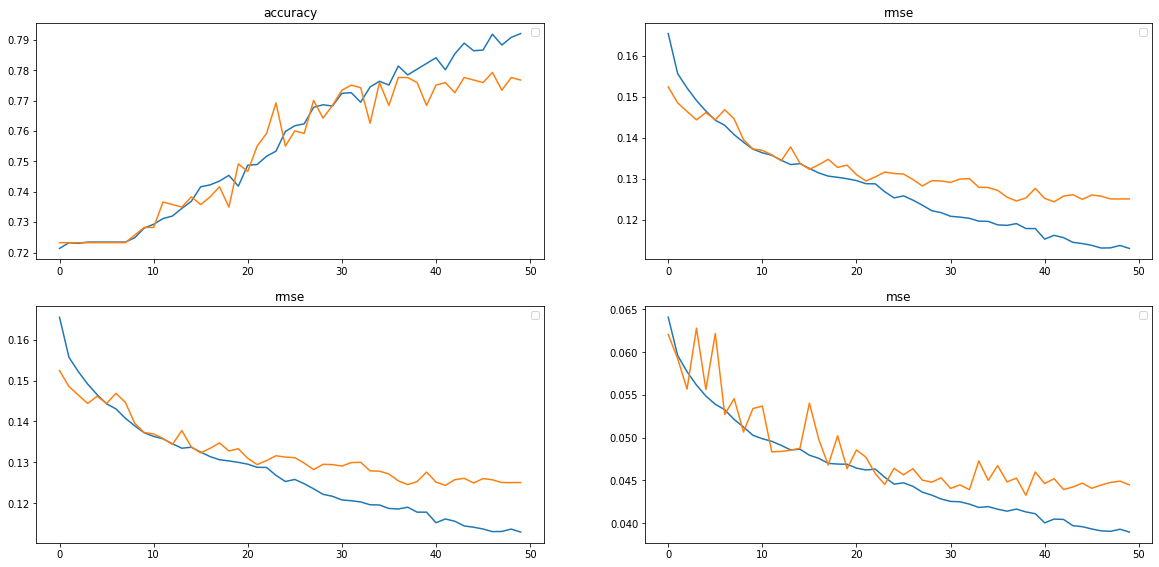

In [ ]:
plt.figure(figsize=(20,20))
plt.subplot(4,2,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend('train','val')
plt.title('accuracy')

plt.subplot(4,2,2)
plt.plot(history.history['rmse'])
plt.plot(history.history['val_rmse'])
plt.legend('train','val')
plt.title('rmse')

plt.subplot(4,2,3)
plt.plot(history.history['rmse'])
plt.plot(history.history['val_rmse'])
plt.legend('train','val')
plt.title('rmse')

plt.subplot(4,2,4)
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.legend('train','val')
plt.title('mse')


In [ ]:
if (ch=="T"): # si vous avez choisi de faire l aprentissage, sauvgarder
  model.save('/content/drive/MyDrive/souad Models/original_cnn_model.h5.h5')

In [ ]:
#essai
loading_dependencies = {
     'rmse': rmse
  }
model = load_model('/content/drive/MyDrive/souad Models/original_cnn_model.h5.h5', custom_objects=loading_dependencies)#le path à adapter si different

In [ ]:
#précision sur l'ensemple de test
test_accuracy(model, x_test_normalized, y_test)

47/47 [==============================] - 2s 38ms/step - loss: 0.8144 - accuracy: 0.7738 - mse: 0.0448 - mape: 36777796.0000 - rmse: 0.1230

Test Set Accuracy:  77.37616896629333 % 
Test Set Loss: 0.814354419708252 
Test Set RMSE: 0.12301281094551086 
Test Set MSE: 0.04479008540511131 
Test Set MAPE: 36777796.0


### 12. InceptionV3

Inception v3 est la troisième édition du réseau neuronal convolutif Inception de Google, largement utilisé et présenté à l'origine lors du concours de reconnaissance ImageNet.

In [ ]:
base_inception_model = InceptionV3(include_top=False, weights="imagenet", input_shape=input_shape)

87924736/87910968 [==============================] - 1s 0us/step


##### ajouter un petit réseau pour adapter a notre probleme

In [ ]:
inception_model = Sequential()
inception_model = add_cnn_layers(base_inception_model, inception_model)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 3, 2, 2048)        21802784  
                                                                 
 conv2d_98 (Conv2D)          (None, 3, 2, 64)          1179712   
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 1, 1, 64)         0         
 2D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 1, 1, 64)          0         
                                                                 
 flatten_1 (Flatten)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 128)               8320      
                                                      

Compiler le modele

In [ ]:
inception_model.compile(optimizer = optimizer , loss = loss, metrics = metrics)

Train ou load

In [ ]:
ch = input("tapez T pour apprentissage (prendre de temps) \ncliquez L pour charger le modèle etrainé")
if(ch=='T'):
  inception_time_callback = TimeHistory()
  inception_csv_logger = CSVLogger('../inception_training.log', separator=',', append=False)
  inception_history = inception_model.fit_generator(augmented_data.flow(x_train_normalized, y_train, batch_size = batch_size),
                                                    epochs = epochs, 
                                                    verbose = 1,
                                                    class_weight = class_weights,
                                                    validation_data = (x_val_normalized, y_val), 
                                                    steps_per_epoch = steps_per_epoch,
                                                    callbacks=[reduce_lr, inception_time_callback, inception_csv_logger])

else:
  inception_model = load_model('/content/drive/MyDrive/souad Models/inception_model_50epochs.h5', custom_objects=loading_dependencies)#à adapter si different


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  # This is added back by InteractiveShellApp.init_path()


Epoch 1/50
478/478 [==============================] - 86s 156ms/step - loss: 1.4134 - accuracy: 0.7149 - mse: 0.0643 - mape: 51792172.0000 - rmse: 0.1689 - val_loss: 1.4436 - val_accuracy: 0.7232 - val_mse: 0.0653 - val_mape: 42841480.0000 - val_rmse: 0.1465 - lr: 1.0000e-05
Epoch 2/50
478/478 [==============================] - 70s 147ms/step - loss: 1.2378 - accuracy: 0.7215 - mse: 0.0593 - mape: 48784508.0000 - rmse: 0.1574 - val_loss: 1.5619 - val_accuracy: 0.7232 - val_mse: 0.0658 - val_mape: 41197424.0000 - val_rmse: 0.1428 - lr: 1.0000e-05
Epoch 3/50
478/478 [==============================] - 71s 147ms/step - loss: 1.1935 - accuracy: 0.7230 - mse: 0.0583 - mape: 47777984.0000 - rmse: 0.1540 - val_loss: 1.2598 - val_accuracy: 0.7232 - val_mse: 0.0632 - val_mape: 41158944.0000 - val_rmse: 0.1407 - lr: 1.0000e-05
Epoch 4/50
478/478 [==============================] - 70s 145ms/step - loss: 1.1655 - accuracy: 0.7222 - mse: 0.0571 - mape: 47255416.0000 - rmse: 0.1518 - val_loss: 1.2354

##### Sauvegarder le modele

In [ ]:
if (ch=="T"): # si vous avez choisi de faire l aprentissage, sauvgarder
  inception_model.save('/content/drive/MyDrive/souad Models/inception_model_50epochs.h5')

<Figure size 1440x1440 with 0 Axes>

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Legend does not support 't' instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Legend does not support 'r' instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Legend does not support 'a' instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  """


Text(0.5, 1.0, 'accuracy')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: Legend does not support 't' instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: Legend does not support 'r' instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: Legend does not support 'a' instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  # This is added back by InteractiveShellApp.init_pa

Text(0.5, 1.0, 'rmse')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: Legend does not support 't' instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: Legend does not support 'r' instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: Legend does not support 'a' instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


Text(0.5, 1.0, 'rmse')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: Legend does not support 't' instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: Legend does not support 'r' instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: Legend does not support 'a' instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


Text(0.5, 1.0, 'mse')

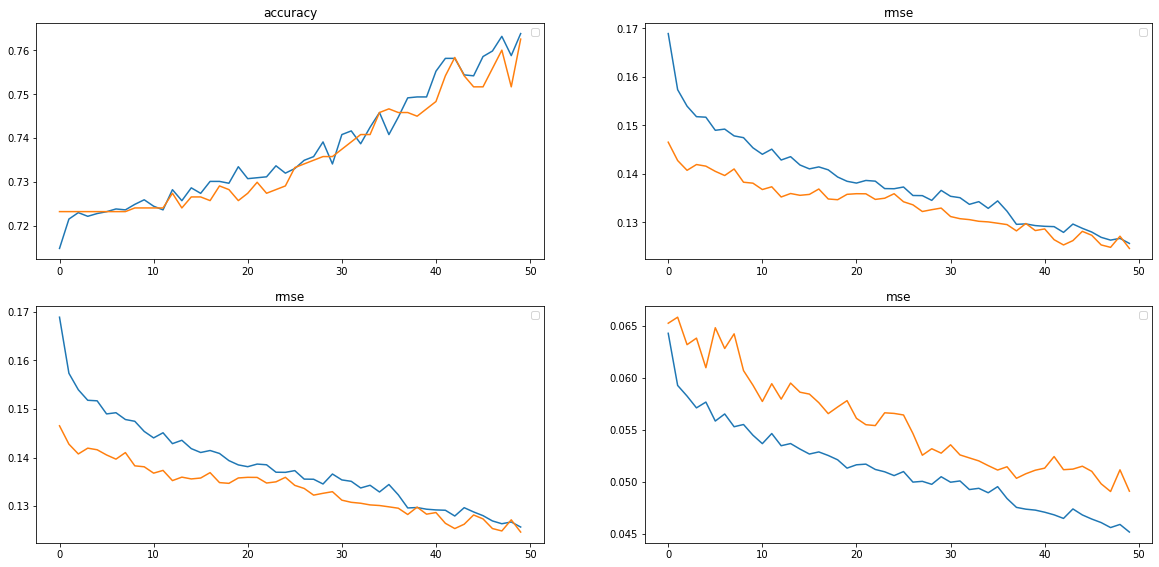

In [ ]:
plt.figure(figsize=(20,20))
plt.subplot(4,2,1)
plt.plot(inception_history.history['accuracy'])
plt.plot(inception_history.history['val_accuracy'])
plt.legend('train','val')
plt.title('accuracy')

plt.subplot(4,2,2)
plt.plot(inception_history.history['rmse'])
plt.plot(inception_history.history['val_rmse'])
plt.legend('train','val')
plt.title('rmse')

plt.subplot(4,2,3)
plt.plot(inception_history.history['rmse'])
plt.plot(inception_history.history['val_rmse'])
plt.legend('train','val')
plt.title('rmse')

plt.subplot(4,2,4)
plt.plot(inception_history.history['mse'])
plt.plot(inception_history.history['val_mse'])
plt.legend('train','val')
plt.title('mse')


In [ ]:
!cp "/content/inception_model_50epochs.h5" "/content/drive/MyDrive/souad Models/"

cp: cannot stat '/content/inception_model_50epochs.h5': No such file or directory


In [ ]:
inception_model_name = "InceptionV3"

In [ ]:
optimizer = Adam(lr=0.0001)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


### 13. ResNet152V2

In [ ]:
base_res_model = ResNet152V2(include_top=False, weights='imagenet', input_tensor=None, input_shape=input_shape, pooling=None, classes=1000)

##### Ajouter plus de couches

In [ ]:
res_model = Sequential()
res_model = add_cnn_layers(base_res_model, res_model)#ajouter un réseau pour adapter à notre probleme

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet152v2 (Functional)    (None, 5, 4, 2048)        58331648  
                                                                 
 conv2d_1 (Conv2D)           (None, 5, 4, 64)          1179712   
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 2, 2, 64)         0         
 2D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 2, 2, 64)          0         
                                                                 
 flatten_1 (Flatten)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                      

##### Compiler le modele

In [ ]:
res_model.compile(optimizer = optimizer , loss = loss, metrics = metrics)

##### train ou load

In [ ]:
ch = input("tapez T pour apprentissage (prendre de temps) \ncliquez L pour charger le modèle etrainé\n")
if(ch=='T'):
  res_time_callback = TimeHistory()
  res_csv_logger = CSVLogger('../res_training.log', separator=',', append=False) 
  res_history = res_model.fit_generator(augmented_data.flow(x_train_normalized, y_train, batch_size = batch_size),
                                        epochs = epochs, 
                                        verbose = 1,
                                        class_weight = class_weights,
                                        validation_data = (x_val_normalized, y_val), 
                                        steps_per_epoch = steps_per_epoch,
                                        callbacks=[reduce_lr, res_time_callback, res_csv_logger])

else:
  res_model = load_model('/content/drive/MyDrive/souad Models/res_model_50epochs.h5', custom_objects=loading_dependencies)#à adapter si different

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  # This is added back by InteractiveShellApp.init_path()


Epoch 1/50
478/478 [==============================] - 102s 183ms/step - loss: 1.5431 - accuracy: 0.7059 - mse: 0.0649 - mape: 50029060.0000 - rmse: 0.1649 - val_loss: 1.1026 - val_accuracy: 0.7232 - val_mse: 0.0639 - val_mape: 40845432.0000 - val_rmse: 0.1412 - lr: 1.0000e-04
Epoch 2/50
478/478 [==============================] - 85s 178ms/step - loss: 1.1565 - accuracy: 0.7243 - mse: 0.0568 - mape: 46525068.0000 - rmse: 0.1503 - val_loss: 0.9624 - val_accuracy: 0.7232 - val_mse: 0.0591 - val_mape: 40899388.0000 - val_rmse: 0.1377 - lr: 1.0000e-04
Epoch 3/50
478/478 [==============================] - 86s 181ms/step - loss: 1.0867 - accuracy: 0.7236 - mse: 0.0563 - mape: 45785928.0000 - rmse: 0.1484 - val_loss: 1.0207 - val_accuracy: 0.7241 - val_mse: 0.0577 - val_mape: 39161556.0000 - val_rmse: 0.1320 - lr: 1.0000e-04
Epoch 4/50
478/478 [==============================] - 86s 181ms/step - loss: 1.0194 - accuracy: 0.7308 - mse: 0.0533 - mape: 44133836.0000 - rmse: 0.1426 - val_loss: 0.895

In [ ]:
if (ch=="T"): # si vous avez choisi de faire l aprentissage, sauvgarder
  res_model.save('/content/drive/MyDrive/souad Models/res_model_50epochs.h5')

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


<Figure size 1440x1440 with 0 Axes>

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Legend does not support 't' instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Legend does not support 'r' instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Legend does not support 'a' instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  """


Text(0.5, 1.0, 'accuracy')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: Legend does not support 't' instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: Legend does not support 'r' instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: Legend does not support 'a' instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  # This is added back by InteractiveShellApp.init_pa

Text(0.5, 1.0, 'rmse')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: Legend does not support 't' instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: Legend does not support 'r' instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: Legend does not support 'a' instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


Text(0.5, 1.0, 'rmse')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: Legend does not support 't' instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: Legend does not support 'r' instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: Legend does not support 'a' instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


Text(0.5, 1.0, 'mse')

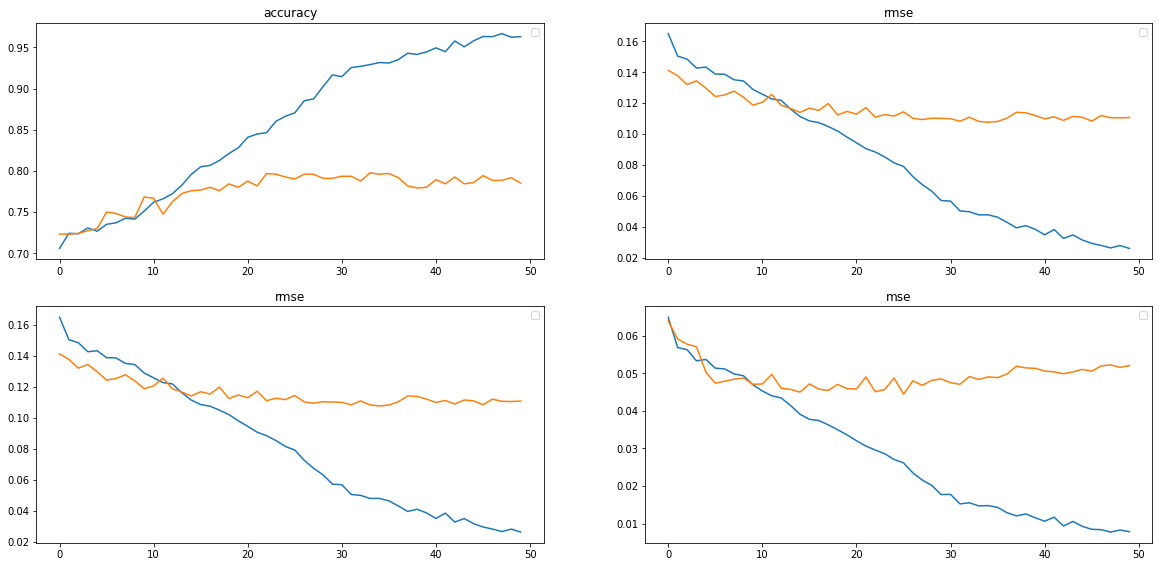

In [ ]:
plt.figure(figsize=(20,20))
plt.subplot(4,2,1)
plt.plot(res_history.history['accuracy'])
plt.plot(res_history.history['val_accuracy'])
plt.legend('train','val')
plt.title('accuracy')

plt.subplot(4,2,2)
plt.plot(res_history.history['rmse'])
plt.plot(res_history.history['val_rmse'])
plt.legend('train','val')
plt.title('rmse')

plt.subplot(4,2,3)
plt.plot(res_history.history['rmse'])
plt.plot(res_history.history['val_rmse'])
plt.legend('train','val')
plt.title('rmse')

plt.subplot(4,2,4)
plt.plot(res_history.history['mse'])
plt.plot(res_history.history['val_mse'])
plt.legend('train','val')
plt.title('mse')

##### Ajouter le nom du modele

In [ ]:
res_model_name = "ResNet152V2"

### 14. VGG16

VGG16 est un modèle de réseau neuronal convolutif à 16 couches proposé par K. Simonyan et A. Zisserman de l'Université d'Oxford dans l'article « Very Deep Convolutional Networks for Large-Scale Image Recognition » 

##### Le modele de base

In [ ]:
base_vgg_model = VGG16(input_shape=input_shape, include_top=False, weights='imagenet')

58900480/58889256 [==============================] - 2s 0us/step


##### Ajouter plus de couches

In [ ]:
vgg_model = Sequential()
vgg_model = add_cnn_layers(base_vgg_model, vgg_model)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 3, 512)         14714688  
                                                                 
 conv2d_4 (Conv2D)           (None, 4, 3, 64)          294976    
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 2, 1, 64)         0         
 2D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 2, 1, 64)          0         
                                                                 
 flatten_1 (Flatten)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 128)               16512     
                                                      

##### compiler le modele

In [ ]:
vgg_model.compile(optimizer = optimizer , loss = loss, metrics = metrics)

Train ou load

In [ ]:
ch = input("tapez T pour apprentissage (prendre de temps) \ncliquez L pour charger le modèle etrainé\n")
if(ch=='T'):
  vgg_time_callback = TimeHistory()
  vgg_csv_logger = CSVLogger('../vgg_training.log', separator=',', append=False) 
  vgg_history = vgg_model.fit_generator(augmented_data.flow(x_train_normalized, y_train, batch_size = batch_size),
                                        epochs = epochs, 
                                        verbose = 1,
                                        class_weight = class_weights,
                                        validation_data = (x_val_normalized, y_val), 
                                        steps_per_epoch = steps_per_epoch,
                                        callbacks=[reduce_lr, vgg_time_callback, vgg_csv_logger])
else:
  vgg_model = load_model('/content/drive/MyDrive/souad Models/vgg_model_50epochs.h5', custom_objects=loading_dependencies)#à adapter si different

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  # This is added back by InteractiveShellApp.init_path()


Epoch 1/50
478/478 [==============================] - 99s 180ms/step - loss: 1.3648 - accuracy: 0.7138 - mse: 0.0635 - mape: 51138268.0000 - rmse: 0.1672 - val_loss: 0.8991 - val_accuracy: 0.7232 - val_mse: 0.0591 - val_mape: 48671908.0000 - val_rmse: 0.1598 - lr: 1.0000e-04
Epoch 2/50
478/478 [==============================] - 80s 167ms/step - loss: 1.1584 - accuracy: 0.7226 - mse: 0.0584 - mape: 47202232.0000 - rmse: 0.1535 - val_loss: 0.8947 - val_accuracy: 0.7232 - val_mse: 0.0583 - val_mape: 43864636.0000 - val_rmse: 0.1459 - lr: 1.0000e-04
Epoch 3/50
478/478 [==============================] - 78s 163ms/step - loss: 1.0886 - accuracy: 0.7243 - mse: 0.0561 - mape: 45886256.0000 - rmse: 0.1486 - val_loss: 0.9486 - val_accuracy: 0.7232 - val_mse: 0.0591 - val_mape: 41709152.0000 - val_rmse: 0.1402 - lr: 1.0000e-04
Epoch 4/50
478/478 [==============================] - ETA: 0s - loss: 1.0389 - accuracy: 0.7230 - mse: 0.0546 - mape: 44885792.0000 - rmse: 0.1448
Epoch 00004: ReduceLROnPl

In [ ]:
if (ch=="T"): # si vous avez choisi de faire l aprentissage, sauvgarder
  vgg_model.save('/content/drive/MyDrive/souad Models/vgg_model_50epochs.h5')

<Figure size 1440x1440 with 0 Axes>

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Legend does not support 't' instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Legend does not support 'r' instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Legend does not support 'a' instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  """


Text(0.5, 1.0, 'accuracy')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: Legend does not support 't' instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: Legend does not support 'r' instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: Legend does not support 'a' instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  # This is added back by InteractiveShellApp.init_pa

Text(0.5, 1.0, 'rmse')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: Legend does not support 't' instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: Legend does not support 'r' instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: Legend does not support 'a' instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


Text(0.5, 1.0, 'rmse')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: Legend does not support 't' instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: Legend does not support 'r' instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: Legend does not support 'a' instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


Text(0.5, 1.0, 'mse')

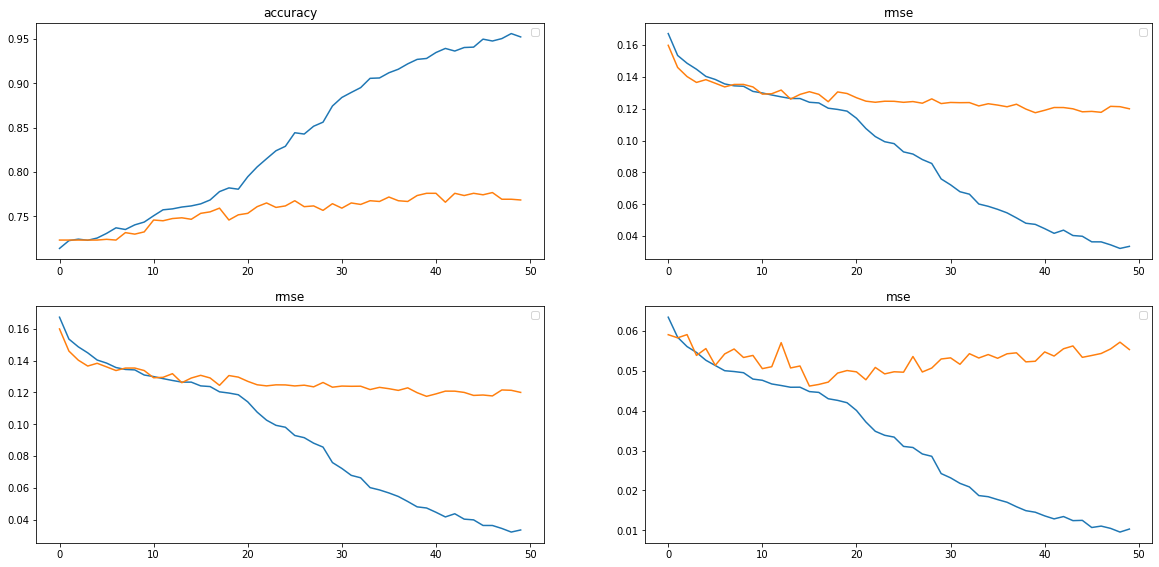

In [ ]:
plt.figure(figsize=(20,20))
plt.subplot(4,2,1)
plt.plot(vgg_history.history['accuracy'])
plt.plot(vgg_history.history['val_accuracy'])
plt.legend('train','val')
plt.title('accuracy')

plt.subplot(4,2,2)
plt.plot(vgg_history.history['rmse'])
plt.plot(vgg_history.history['val_rmse'])
plt.legend('train','val')
plt.title('rmse')

plt.subplot(4,2,3)
plt.plot(vgg_history.history['rmse'])
plt.plot(vgg_history.history['val_rmse'])
plt.legend('train','val')
plt.title('rmse')

plt.subplot(4,2,4)
plt.plot(vgg_history.history['mse'])
plt.plot(vgg_history.history['val_mse'])
plt.legend('train','val')
plt.title('mse')

##### Ajouter le nom du modele

In [ ]:
vgg_model_name = "VGG16"

### 15. Calculer Training et Validation Sets Accuracy + perte + Erreurs

##### Basic CNN

In [ ]:
train_val_accuracy(model, x_train_normalized, x_val_normalized, y_train, y_val)

38/38 [==============================] - 1s 27ms/step - loss: 0.7800 - accuracy: 0.7768 - mse: 0.0445 - mape: 37246060.0000 - rmse: 0.1251
Training Accuracy: 80.04184365272522 % 
Validation Accuracy: 77.67558693885803 % 

Training Loss: 0.5591399073600769
Validation Loss: 0.7800482511520386

Training RMSE: 0.11283357441425323
Validation RMSE: 0.12506826221942902

Training MSE: 0.038267482072114944
Validation MSE: 0.04448002204298973

Training MAPE: 34008884.0
Validation MAPE: 37246060.0


##### InceptionV3

In [ ]:
train_val_accuracy(inception_model, x_train_normalized, x_val_normalized, y_train, y_val)

38/38 [==============================] - 3s 81ms/step - loss: 0.7619 - accuracy: 0.7625 - mse: 0.0491 - mape: 37340336.0000 - rmse: 0.1246
Training Accuracy: 77.07113027572632 % 
Validation Accuracy: 76.25418305397034 % 

Training Loss: 0.6453295350074768
Validation Loss: 0.7619149088859558

Training RMSE: 0.11544748395681381
Validation RMSE: 0.1246330589056015

Training MSE: 0.04495172202587128
Validation MSE: 0.04911448433995247

Training MAPE: 34824344.0
Validation MAPE: 37340336.0


##### ResNet152V2

In [ ]:
train_val_accuracy(res_model, x_train_normalized, x_val_normalized, y_train, y_val)

38/38 [==============================] - 4s 105ms/step - loss: 1.3580 - accuracy: 0.7851 - mse: 0.0520 - mape: 30724388.0000 - rmse: 0.1107
Training Accuracy: 99.43514466285706 % 
Validation Accuracy: 78.51170301437378 % 

Training Loss: 0.020878983661532402
Validation Loss: 1.3579679727554321

Training RMSE: 0.005090371705591679
Validation RMSE: 0.11073718219995499

Training MSE: 0.0013419101014733315
Validation MSE: 0.052000902593135834

Training MAPE: 1492929.125
Validation MAPE: 30724388.0


##### VGG16

In [ ]:
train_val_accuracy(vgg_model, x_train_normalized, x_val_normalized, y_train, y_val)

38/38 [==============================] - 4s 100ms/step - loss: 1.4186 - accuracy: 0.7684 - mse: 0.0554 - mape: 33686620.0000 - rmse: 0.1200
Training Accuracy: 94.56067085266113 % 
Validation Accuracy: 76.83946490287781 % 

Training Loss: 0.17969931662082672
Validation Loss: 1.4185880422592163

Training RMSE: 0.034560151398181915
Validation RMSE: 0.1199660673737526

Training MSE: 0.011820548214018345
Validation MSE: 0.05535132810473442

Training MAPE: 9987396.0
Validation MAPE: 33686620.0


Pour les modeles ResNet152 et VGG16 -> high bias ->overfitting

Pour les modeles TSM12 et InceptionV3->low bias -> ni overfitting ni underfitting

### 16. Historiques 

Les historiques des modeles sont très importants pour s'assurer que l'apprentissage continue sans erreurs

##### Basic CNN

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2;

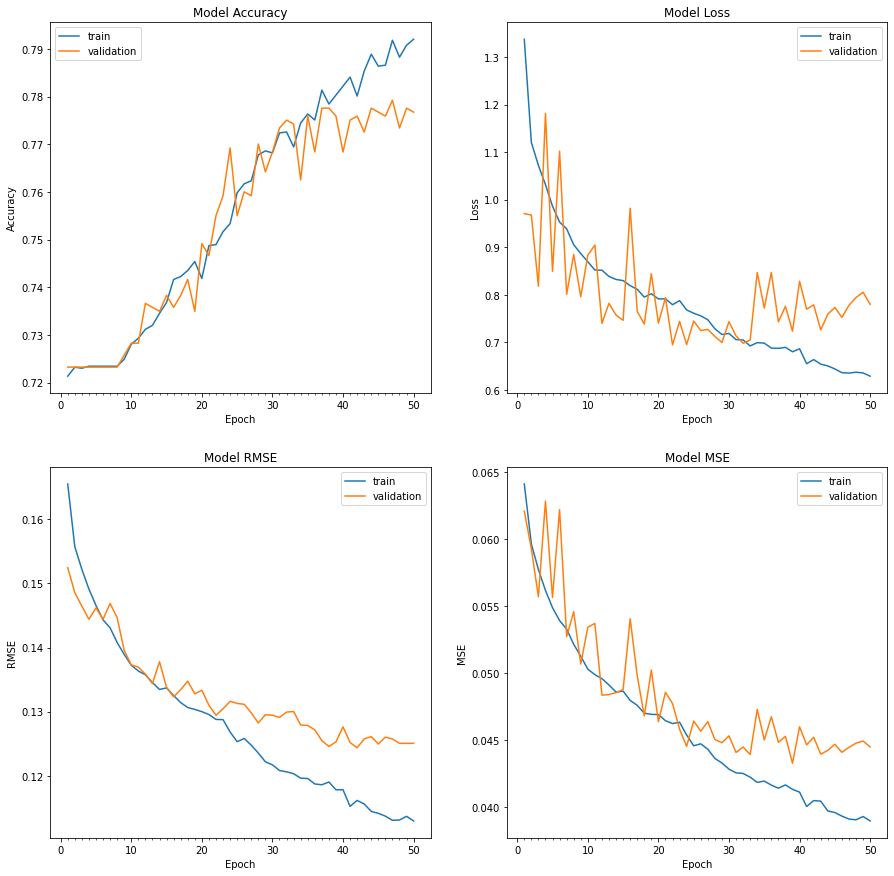

In [ ]:
plot_model_history(history, "BasicCNN")

![OwnCNN](../Photos/owncnn_history.png "CNN")

##### InceptionV3

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2;

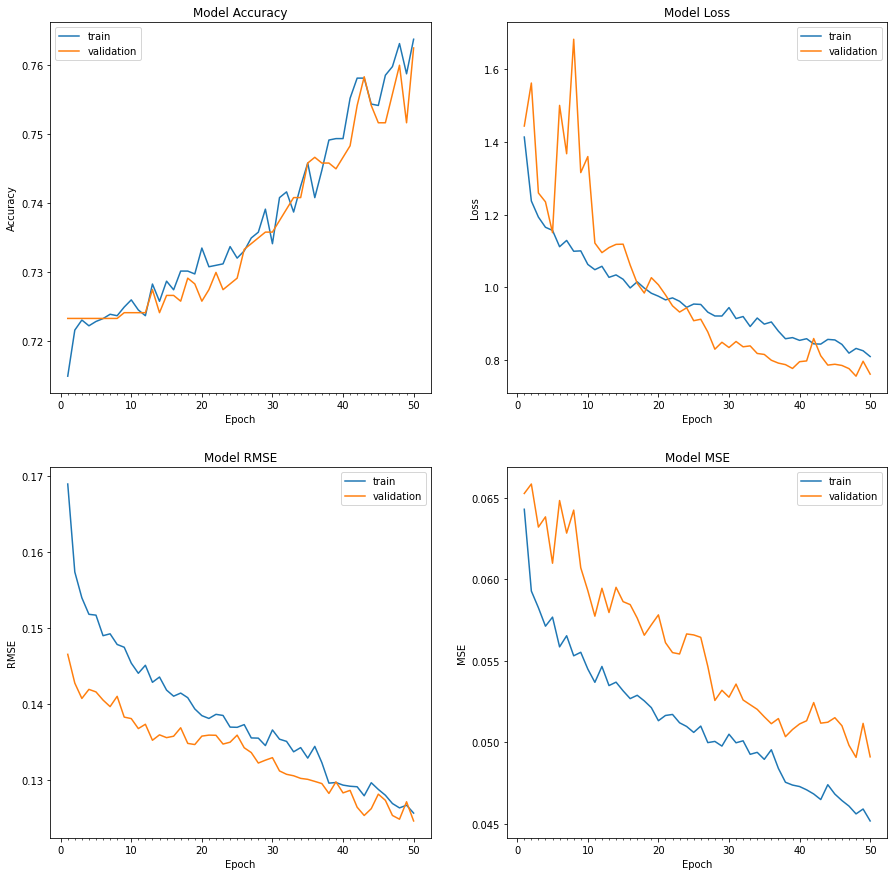

In [ ]:
plot_model_history(inception_history, "InceptionV3")

![InceptionV3](../Photos/inception_history.png "CNN")

##### ResNet152V2

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2;

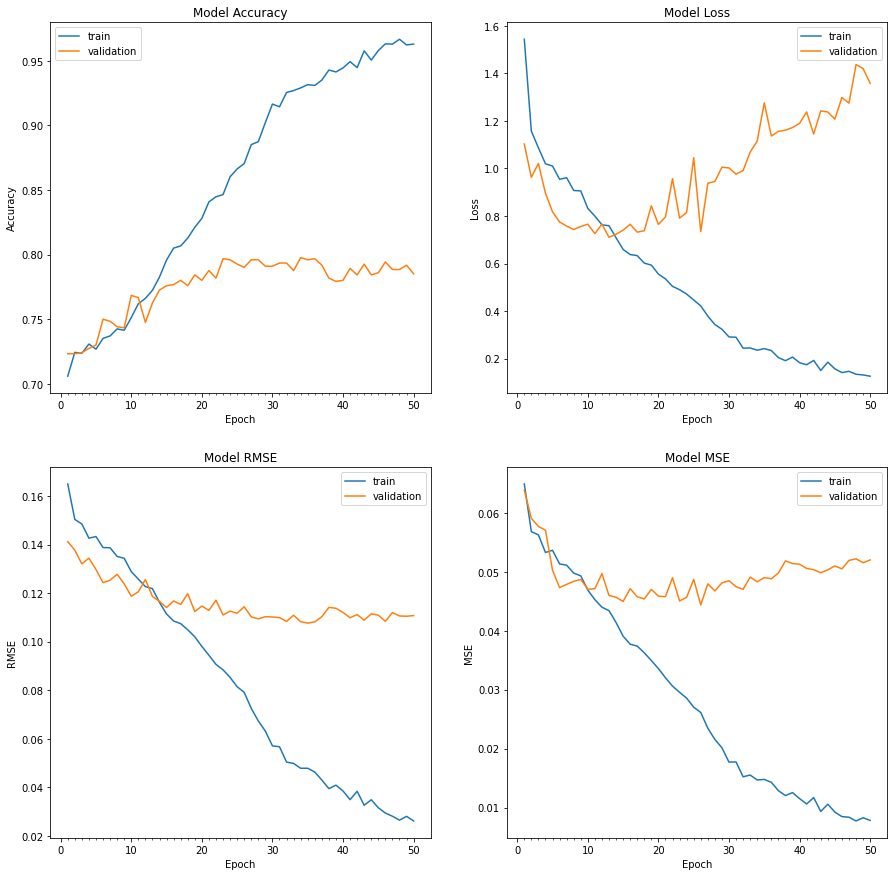

In [ ]:
plot_model_history(res_history, "ResNet152V2")

![ResNet](../Photos/resv2_history.png "CNN")

##### VGG16

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2;

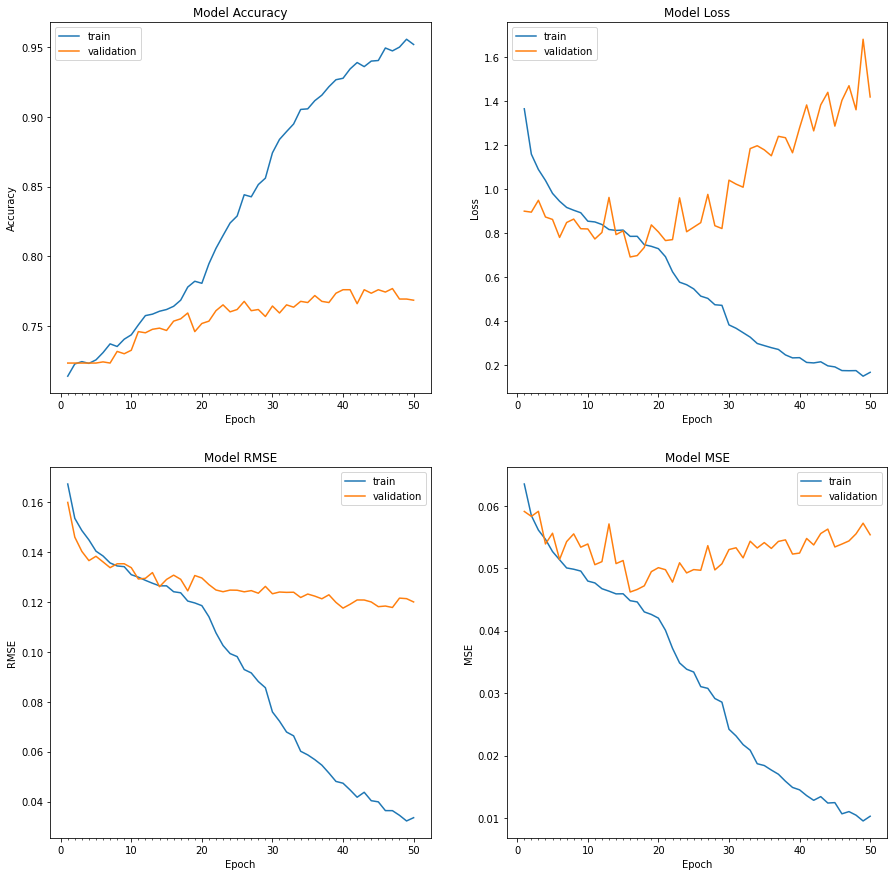

In [ ]:
plot_model_history(vgg_history, "VGG16")

![VGG16](../Photos/vgg_history.png "CNN")

### 17. Calculer Testing Set Accuracy + perte + Erreurs

##### Basic CNN

In [ ]:
test_accuracy(model, x_test_normalized, y_test)

47/47 [==============================] - 1s 29ms/step - loss: 0.8144 - accuracy: 0.7738 - mse: 0.0448 - mape: 36777796.0000 - rmse: 0.1230

Test Set Accuracy:  77.37616896629333 % 
Test Set Loss: 0.814354419708252 
Test Set RMSE: 0.12301281094551086 
Test Set MSE: 0.04479008540511131 
Test Set MAPE: 36777796.0


##### InceptionV3

In [ ]:
test_accuracy(inception_model, x_test_normalized, y_test)

47/47 [==============================] - 5s 105ms/step - loss: 0.8347 - accuracy: 0.7497 - mse: 0.0532 - mape: 38191008.0000 - rmse: 0.1288

Test Set Accuracy:  74.96653199195862 % 
Test Set Loss: 0.8347115516662598 
Test Set RMSE: 0.12878017127513885 
Test Set MSE: 0.05324888974428177 
Test Set MAPE: 38191008.0


##### ResNet152V2

In [ ]:
test_accuracy(res_model, x_test_normalized, y_test)

47/47 [==============================] - 6s 121ms/step - loss: 1.4529 - accuracy: 0.7845 - mse: 0.0525 - mape: 31471064.0000 - rmse: 0.1134

Test Set Accuracy:  78.44712138175964 % 
Test Set Loss: 1.4529409408569336 
Test Set RMSE: 0.11337902396917343 
Test Set MSE: 0.052465613931417465 
Test Set MAPE: 31471064.0


##### VGG16

In [ ]:
test_accuracy(vgg_model, x_test_normalized, y_test)

47/47 [==============================] - 8s 166ms/step - loss: 1.4365 - accuracy: 0.7657 - mse: 0.0562 - mape: 33849644.0000 - rmse: 0.1215

Test Set Accuracy:  76.57296061515808 % 
Test Set Loss: 1.4364815950393677 
Test Set RMSE: 0.12148981541395187 
Test Set MSE: 0.056209128350019455 
Test Set MAPE: 33849644.0


En utilisant une approche naive càd ignorer l'overfitting. Le classement des modeles serait : 

ResNet152V2 -> VGG16 -> TSM12 -> InceptionV3

### 18. Testing Set Confusion Matrix for True vs Predicted Labels

##### Matrice de confusion 

In [ ]:
#Definir les labels
cm_plot_labels=['akiec', 'bcc', 'bkl', 'df', 'nv','mel', 'vasc']

##### Basic CNN

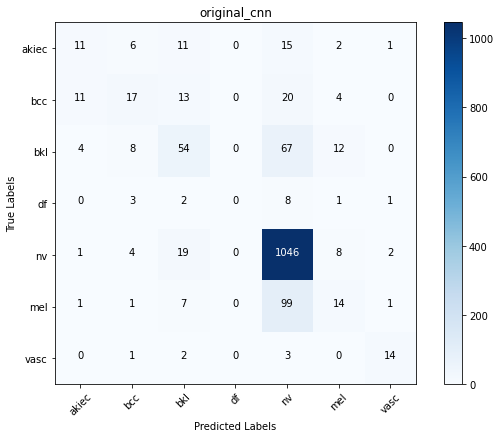

In [ ]:
create_confusion_matrix(model, x_test_normalized, y_test, cm_plot_labels,"original_cnn")

##### InceptionV3

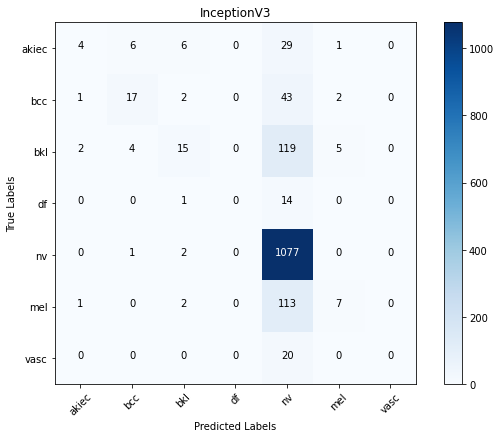

In [ ]:
create_confusion_matrix(inception_model, x_test_normalized, y_test, cm_plot_labels, inception_model_name)

##### ResNet152V2

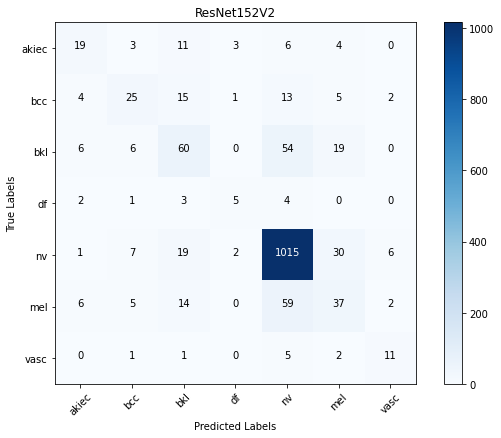

In [ ]:
create_confusion_matrix(res_model, x_test_normalized, y_test, cm_plot_labels, res_model_name)

##### VGG16

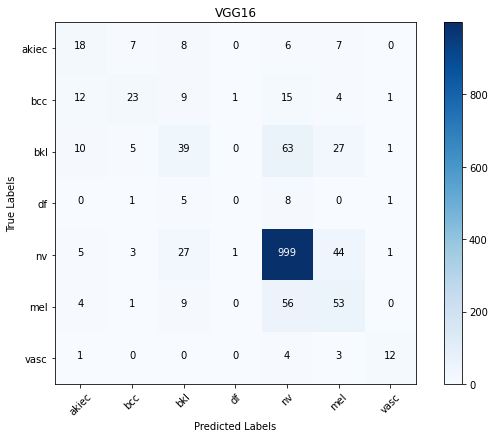

In [ ]:
create_confusion_matrix(vgg_model, x_test_normalized, y_test, cm_plot_labels, vgg_model_name)

### 19. Generation du rapport de la matrice de confusion

##### Basic CNN

In [ ]:
gen_classification_report(model, x_test_normalized, y_test, cm_plot_labels)

              precision    recall  f1-score   support

       akiec       0.39      0.24      0.30        46
         bcc       0.42      0.26      0.32        65
         bkl       0.50      0.37      0.43       145
          df       0.00      0.00      0.00        15
          nv       0.83      0.97      0.89      1080
         mel       0.34      0.11      0.17       123
        vasc       0.74      0.70      0.72        20

    accuracy                           0.77      1494
   macro avg       0.46      0.38      0.40      1494
weighted avg       0.72      0.77      0.74      1494



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


##### InceptionV3

In [ ]:
gen_classification_report(inception_model, x_test_normalized, y_test, cm_plot_labels)

              precision    recall  f1-score   support

       akiec       0.50      0.09      0.15        46
         bcc       0.61      0.26      0.37        65
         bkl       0.54      0.10      0.17       145
          df       0.00      0.00      0.00        15
          nv       0.76      1.00      0.86      1080
         mel       0.47      0.06      0.10       123
        vasc       0.00      0.00      0.00        20

    accuracy                           0.75      1494
   macro avg       0.41      0.22      0.24      1494
weighted avg       0.68      0.75      0.67      1494



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


##### ResNet152V2

In [ ]:
gen_classification_report(res_model, x_test_normalized, y_test, cm_plot_labels)

              precision    recall  f1-score   support

       akiec       0.50      0.41      0.45        46
         bcc       0.52      0.38      0.44        65
         bkl       0.49      0.41      0.45       145
          df       0.45      0.33      0.38        15
          nv       0.88      0.94      0.91      1080
         mel       0.38      0.30      0.34       123
        vasc       0.52      0.55      0.54        20

    accuracy                           0.78      1494
   macro avg       0.54      0.48      0.50      1494
weighted avg       0.76      0.78      0.77      1494



##### VGG16

In [ ]:
gen_classification_report(vgg_model, x_test_normalized, y_test, cm_plot_labels)

              precision    recall  f1-score   support

       akiec       0.36      0.39      0.37        46
         bcc       0.57      0.35      0.44        65
         bkl       0.40      0.27      0.32       145
          df       0.00      0.00      0.00        15
          nv       0.87      0.93      0.90      1080
         mel       0.38      0.43      0.41       123
        vasc       0.75      0.60      0.67        20

    accuracy                           0.77      1494
   macro avg       0.48      0.42      0.44      1494
weighted avg       0.74      0.77      0.75      1494



Selon les performances, le classement serait 

ResNet152V2 -> VGG16 -> TSM12 -> InceptionV3

### 20. Skin categories

##### Basic CNN

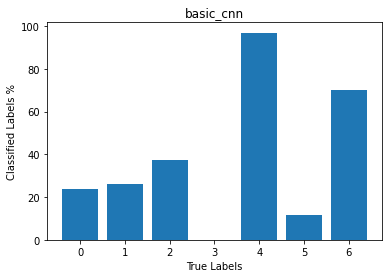

In [ ]:
plot_label_classification_acc(model, x_test_normalized, y_test, cm_plot_labels, "basic_cnn")

##### InceptionV3

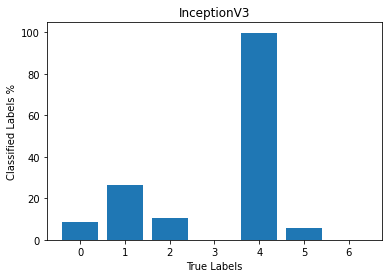

In [ ]:
plot_label_classification_acc(inception_model, x_test_normalized, y_test, cm_plot_labels, inception_model_name)

##### ResNet152V2

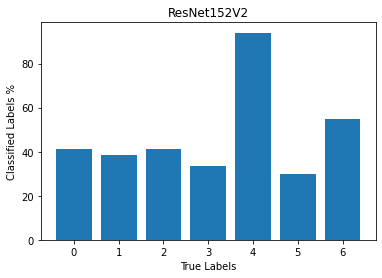

In [ ]:
plot_label_classification_acc(res_model, x_test_normalized, y_test, cm_plot_labels, res_model_name)

##### VGG16

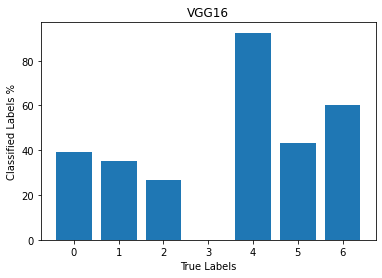

In [ ]:
plot_label_classification_acc(vgg_model, x_test_normalized, y_test, cm_plot_labels, vgg_model_name)

Les 4 modèles ont une accuracy supérieure à 85% pour la classe Melanocytic Nevi [nv] (Classe avec nombre maximum d’images). Pour les autres classes, les valeurs sont différentes pour chaque modèle.

Bien au contraire, les 4 modèles ont des valeurs d’accuracy minimes pour la classe Dermatofibroma [df] (Classe avec nombre minimum d’images).

On voit que le modèle InceptionV3 a eu des résultats inférieurs aux autres (le moins performant).

On peut conclure que plus il plus d’images, plus les modèles sont plus performants.


### 21. Conclusion

Ce projet avait pour but de comparer les différentes architectures Cnn dans la prédiction des lésions cutanées sur des images de lésions cutanées.

La base de données a été prétraité par : le nettoyage de données-la division des données-la normalisation- l’augmentation et le redimensionnement de données. 

Nous avons construit une nouvelle architecture Cnn appelée TSM12. Nous avons utilisé d’autres modèles existants : InceptionV3, ResNet152V2 et VGG16.
Des hyperparamètres et des métriques ont été utilisés pour comparer entre les modèles.

Selon l’article le modèle VGG16 était le plus performant, mais en considérants nos résultats et en ignorant l’overfitting, le modèle ResNet152V2 était plus performant que VGG16.

Et enfin nous pouvons dire que plus les données sont plus larges pour une classe, plus l’apprentissage est meilleur. 

Il est conseillé d’augmenter les données pour la classe des lésions malignes pour une meilleur prédiction de ces tumeurs.
